In [67]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import ipywidgets as widgets
import math
from IPython.display import display
from math import comb

Chance for a single die is mutually exclusive and exhaustive
D1 = dice is 1
D2 = dice is 2
D6 = dice is 6
P(D1) = P(D2) = P(D6) = 1/6
P(D1 v D2 v ... v D6) = 1
P(D1 & D2) = P(D2 & D6) = 0

Part 1: 
With 63 points in first round, we get a bonus of 50 points.
- We want to have an average of three of a kind in each instance because that will give us the bonus.
P(D1)
We should always try to get the bonus.

We also don't want the very lowest number to have too much of a say, so we penalize it

In [68]:
def inference_partOne(dice, available):
    
    p_outcome = 1/6
    p_not_outcome = 1-p_outcome
    
    #Dictionary of the choices and their given score at the end
    prob_dict = {}

    for d in set(dice):
        #only do inference if the dice has not been alreay used
        if (d in available):
            # How many of a kind
            count = dice.count(d)

            # Probability of a yahtzee our next turn.
            ytzy_prob = math.pow(p_outcome, 5-count)
            
            # probability that somethings gets 3 of a kind. Heavily benefits if its over, even though its still just 100% likely.
            beat3x_prob = math.pow(p_outcome,(3-count))
            
            # Overall score calculated on the probabilities and dice
            ovral_score = (ytzy_prob+beat3x_prob)
            
            # Reduce the weight of the overall score for number 1,
            # by 1/3
            if (d == 1):
                ovral_score = ovral_score*(1-1/3)
                
            # Round of because we dont care about super small variations in probability
            prob_dict[d] = round(ovral_score, 6)
        else:
            prob_dict[d] = 0

    return prob_dict        

In [69]:
def probabilityThreeOfAKind(dice, similar):
    # Probability of rolling a specific number on a die
    p_outcome = len(similar) / 6
    n_p_outcome = 1-p_outcome

    # Number of dice with the same face as the first "similar" value
    target_count = dice.count(similar[0])

    # n = number of dice we're rolling
    # k = number of additional dice needed to match the value we're aiming for
    n = len(dice)-target_count
    k = 3-target_count

    results = (comb(n, k))*(p_outcome**k)*(n_p_outcome**(n-k))


    return results


In [70]:
def keepMutipleInference(dice, similar):
#Dictionary of the choices and their given score at the end
    p_outcome = 1/6
    keep_dict = {}
    count = dice.count(similar[0])
    
    for i in range(len(similar)):
        index = i+1
        p_ytze = 0
        p_3x = 0
        dice_to_roll = 5-(count*index)
        
        #Its only possible with yahtzee if we keep 1 kind.
        if (index == 1):
            p_ytze = math.pow(p_outcome, 5-count)

        p_3x = probabilityThreeOfAKind(dice, similar[:index])
        
        ovral = p_ytze + p_3x

        keep_dict[index] = round(ovral, 6)

    return keep_dict



In [71]:
# Returns the number of (amount) different dice we should keep. Not the specific type of dice. 
def keepDiceDecision(dice, available, prob_dict):
    
    # By default we keep one dice
    keepDice = [0]
    
    # Find highest probabilities, can be multiple 
    high_die = max(prob_dict, key=prob_dict.get)
    same_value_dice = [key for key, value in prob_dict.items() if value == prob_dict[high_die]]
    
    
    # Use keepMultipleInference to check how many dice we should keep
    if len(same_value_dice) > 1:
        keepMultiple = keepMutipleInference(dice, same_value_dice)
        keepDice = max(keepMultiple, key=keepMultiple.get)

        same_value_dice.sort(reverse=True)
        keepDice = same_value_dice[:keepDice]
    else:
        keepDice = [high_die]

    return keepDice

In [72]:
def keepDice(dice, prob_dict, available):
    
    # If we didnt roll any available dice, reroll all dice
    if not any(key in available for key in prob_dict.keys()):
        return [0]

    return keepDiceDecision(dice, available, prob_dict)


In [73]:
def rollDice():
    return sorted([random.randint(1, 6) for _ in range(5)])

def rollDiceKeepType(dice, keep):
    copy = dice.copy()
    for i in range(len(dice)):
        if (not dice[i] in keep):
            copy[i] = random.randint(1,6)
    
    return sorted(copy)


In [74]:
def endTurnDecision(dice, kept, available):

    # If we didnt get anything good on our last throw we should do some basic inference
    if kept[0] == 0:

        prob_dict = inference_partOne(dice, available)
        kpt = keepDice(dice, prob_dict, available)
        
        if kpt[0] == 0:
            return available[0]
        else:
            kept = kpt
            
    
    amount = dice.count(kept[0])
    
    # if we have a 4, 5 or 6 which is less than 3 and we have a spare 1 available, use the one as extra life.
    if (amount < 3) and any(x in kept for x in [4, 5, 6]) and (1 in available):
        return available[0]
    
    return kept[-1]

    if amount >= 3:
        return kept[-1]
    
    if amount < 3:
        return kept[0]



In [75]:
def oneGameSim(dice, available):

    kept = []
    #Test specific dice combination
    #dice = [1,1,1,4,4]
    turn = 2
    for i in range (turn):
        # Calculate probability for high scores
        prob_dict = inference_partOne(dice, available)
        # Get the one that is kept based on prob_dict
        kept = keepDice(dice, prob_dict, available)
        dice = rollDiceKeepType(dice, kept)
        
    
    eTD = endTurnDecision(dice, kept, available)
    count = dice.count(eTD)
    score = count*eTD

    
    return (score, eTD)
    

In [107]:
repeat = 400000
round_one_score = 0
game_score = 0
games_score = {}
times_yahtzee = 0
times_yahtzee_and_63 = 0

# Game Simulation
for _ in range(repeat):
    available = [1, 2, 3, 4, 5, 6]
    score = 0
    yahtzee = False
    while(len(available) > 0):
        dice = rollDice()
        s, k = oneGameSim(dice, available)
        if(s/k == 5) and not yahtzee:
            yahtzee = True
            game_score += 50
            times_yahtzee += 1
        else:
            available.remove(k)
            score += s
    round_one_score += score
    game_score += score
    
    if (yahtzee) and (score >= 63):
        times_yahtzee_and_63 += 1

    if score not in games_score:
        games_score[score] = 1
    else:
        games_score[score] += 1

# Add logic for final selection
# [6,6,2,3,3] as a final roll will say we should pick 6, but then we use up that spot.


AVG score after 400000 games : 55
Times player got yahtzee : 64556
Times player got yahtzee and over 63 : 15554

Percentage of games overall score was 63 or higher: 20.383%
percentage of games :: yahtzee : 16.1%
percentage of games :: yahtzee and score over 63 : 3.9%


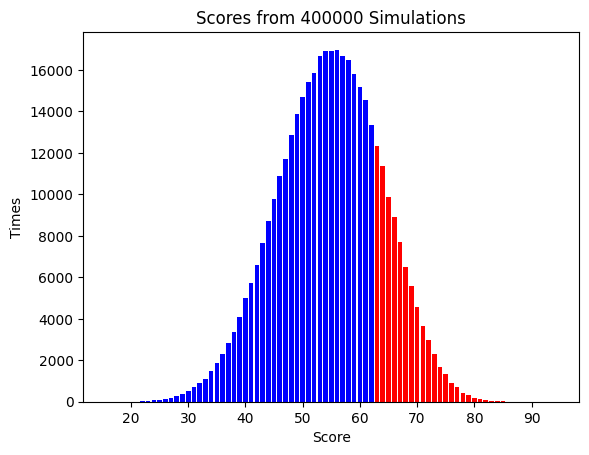

In [121]:
# Benchmark from our programmed inference and decision

print(f"AVG score after {repeat} games : {round(round_one_score/repeat)}")
print(f"Times player got yahtzee : {times_yahtzee}")
print(f"Times player got yahtzee and over 63 : {times_yahtzee_and_63}")
print("")
# Calculate the percentage of times the overall score was 63 or higher
high_score_count = sum(count for score, count in games_score.items() if score >= 63)
percentage_high_score = (high_score_count / repeat) * 100
print(f"Percentage of games overall score was 63 or higher: {round(percentage_high_score,3)}%")

print(f"percentage of games :: yahtzee : {round((times_yahtzee/repeat),3)*100}%")

print(f"percentage of games :: yahtzee and score over 63 : {round((times_yahtzee_and_63/repeat),3)*100}%")
# Plotting the scores from games_score
colors = ['red' if score >= 63 else 'blue' for score in games_score.keys()]
plt.bar(games_score.keys(), games_score.values(), color=colors)
plt.xlabel('Score')
plt.ylabel('Times')
plt.title(f'Scores from {repeat} Simulations')
plt.show()